### **IMPORTING LIBRARIES**

In [535]:
import scipy.ndimage
import skimage.color
import skimage.io
import skimage.transform
from matplotlib import pyplot as plt
import numpy as np
from math import exp
import torch
from colormap import rgb2hex
import colorsys
import math
from scipy.sparse.linalg import eigsh
from skimage.transform import rescale, resize, downscale_local_mean
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### **USING INTENSITY SIMILARITY**

In [536]:
def get_weights_by_intensity(image,limit_distance):
  #this function gets weights with a cutoff distance passed in arguments
  weights=np.zeros([image.shape[0]*image.shape[1],image.shape[0]*image.shape[1]])
  R = image[:, :, 0].flatten()
  G = image[:, :, 1].flatten()
  B = image[:, :, 2].flatten()

  image_flattened= np.zeros([image.shape[0]*image.shape[1], 3]).astype(int)
  
  channels=[R,G,B]
  
  for k in range(3):
    image_flattened[:,k]=channels[k]  #flattened RGB channels

  print(weights.shape)

  sigma_i = 10
  sigma_x = 15
  range_dist=limit_distance
  limit_dist = range_dist**2
  width=image.shape[1]

  total_size=image.shape[0]*image.shape[1]


  for i in range(total_size):
    for j in range(i+1):
  
      p1_i = int(i/width)
      p1_j = i - p1_i * width
      p2_i = int(j/width)
      p2_j = j - p2_i * width

      distance = ((p1_i - p2_i)**2 + (p1_j - p2_j)**2)

      p1_intensity = (image_flattened[i][0]+image_flattened[i][1]+image_flattened[i][2])/3
      p2_intensity = (image_flattened[j][0]+image_flattened[j][1]+image_flattened[j][2])/3

      inten_dist = abs(p1_intensity - p2_intensity)   #intensity distance between pixels

      if distance < limit_dist:

        weights[i][j] = exp(-(inten_dist**2)/sigma_i) * exp(-(distance)/sigma_x)    #similarity calculation
        weights[j][i] = weights[i][j]
    
  
  return weights

   

  

In [537]:
def get_weights_by_intensity_without_dist(image):
  #this function gets weights with no cutoff distance 
  weights=np.zeros([image.shape[0]*image.shape[1],image.shape[0]*image.shape[1]])
  R = image[:, :, 0].flatten()
  G = image[:, :, 1].flatten()
  B = image[:, :, 2].flatten()

  image_flattened= np.zeros([image.shape[0]*image.shape[1], 3]).astype(int)
  
  channels=[R,G,B]
  
  for k in range(3):
    image_flattened[:,k]=channels[k]

  print(weights.shape)

  sigma_i = 10
  sigma_x = 15
  width=image.shape[1]

  total_size=image.shape[0]*image.shape[1]


  for i in range(total_size):
    for j in range(i+1):

    
      p1_intensity = (image_flattened[i][0]+image_flattened[i][1]+image_flattened[i][2])/3
      p2_intensity = (image_flattened[j][0]+image_flattened[j][1]+image_flattened[j][2])/3
      

      inten_dist = abs(p1_intensity - p2_intensity) #intensity distance between pixels

      weights[i][j] = exp(-(inten_dist**2)/sigma_i) #similarity calculation
      weights[j][i] = weights[i][j]
    
 
  return weights

   

  

In [538]:
def get_EV(W):
  #this function gets eigen vectors
  D = np.zeros(W.shape)
  for i in range(W.shape[0]):
      D[i, i] = np.sum(W[i, :]) #degree matrix entries (diagonals)

  A = D - W
  B = D

  A=torch.tensor(A)
  B=torch.tensor(B)
  A=A.to(device)
  B=B.to(device)

  eigvals, eigvecs = torch.lobpcg(A, 2, B=B,largest=False,niter=100) #calculates eigen vectors
  return eigvecs

def get_A_B(W): #gets A and B matrics
  D = np.zeros(W.shape)
  for i in range(W.shape[0]):
      D[i, i] = np.sum(W[i, :])

  A = D - W
  B = D

  return A,B



In [539]:
def get_segmentation(eigvecs,threshold):
  #this function gets segmentation done for a given eigen vector threshold
  if threshold =='median':
    second_smallest_ev = eigvecs[:, 1].cpu().numpy() > np.median(eigvecs[:, 1].cpu().numpy())
  elif threshold == 'mean':
    second_smallest_ev = eigvecs[:, 1].cpu().numpy() > np.mean(eigvecs[:, 1].cpu().numpy())
  else :
    second_smallest_ev = eigvecs[:, 1].cpu().numpy() > threshold

  segmented_image = second_smallest_ev.reshape((image.shape[0], image.shape[1]))
  plt.imshow(segmented_image, cmap='gray')
  plt.show()

In [540]:
def get_resized_image(image,size):
  #the function returns resizes images
  image=resize(image, size,anti_aliasing=False)
  image= (image[:, :, :3] * 255).astype(int)
  plt.imshow(image)
  return image

### **TESTING IMAGES**

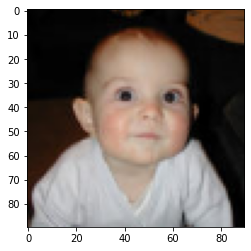

In [578]:
image=skimage.io.imread('test2.jpg')
#image = skimage.transform.rotate(image, 60)
#image = skimage.util.random_noise(image, mode='gaussian') 
image=get_resized_image(image,(90,90))
plt.imshow(image)

In [579]:
W = get_weights_by_intensity_without_dist(image)

(8100, 8100)


In [580]:
eigvecs= get_EV(W)

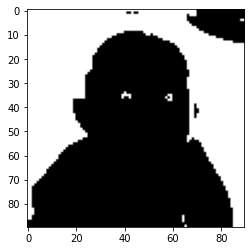

In [581]:
get_segmentation(eigvecs,1e-6)

In [584]:
A,B=get_A_B(W)
y = eigvecs[:, 1].cpu().numpy() > (1e-6)
X=y
print("Ncut value")
print(np.einsum('...i,...i->...', X.T.dot(A), X.T)/np.einsum('...i,...i->...', X.T.dot(B), X.T))

Ncut value
0.00010155325081788696


### **USING COLOR SIMILARITY**

In [546]:
def get_weights_by_color(image):
  #this function calculates similairty by color differnce between pixels
  weights=np.zeros([image.shape[0]*image.shape[1],image.shape[0]*image.shape[1]])
  R = image[:, :, 0].flatten()
  G = image[:, :, 1].flatten()
  B = image[:, :, 2].flatten()

  image_flattened= np.zeros([image.shape[0]*image.shape[1], 3]).astype(int)
  
  channels=[R,G,B]
  
  for k in range(3):
    image_flattened[:,k]=channels[k]

  print(weights.shape)

  sigma_i = 10
  sigma_x = 15

  width=image.shape[1]

  total_size=image.shape[0]*image.shape[1]

  for i in range(total_size):
    for j in range(i+1):

      #calculating feature based on color
      h1,s1,v1 = colorsys.rgb_to_hsv(image_flattened[i][0], image_flattened[i][1], image_flattened[i][2])
      F1 = np.array([v1, v1* s1*math.sin(h1), v1* s1*math.cos(h1) ])
      h2,s2,v2 = colorsys.rgb_to_hsv(image_flattened[j][0], image_flattened[j][1], image_flattened[j][2])
      F2 = np.array([v2, v2* s2*math.sin(h2), v2* s2*math.cos(h2) ])

      color_dist = np.linalg.norm(F1-F2)

      weights[i][j] = exp(-(color_dist**2)/sigma_i) 
      weights[j][i] = weights[i][j]
    
   
  return weights


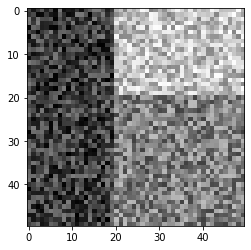

In [547]:
image=skimage.io.imread('test1.png')
#image = skimage.transform.rotate(image, 60)
#image = skimage.util.random_noise(image, mode='gaussian') 
image=get_resized_image(image,(50,50))
plt.imshow(image)

### **TESTING IMAGES**

In [548]:
W = get_weights_by_color(image)

(2500, 2500)


In [549]:
eigvecs= get_EV(W)

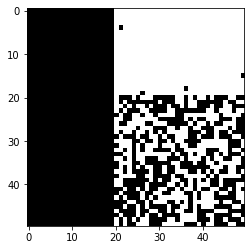

In [550]:
get_segmentation(eigvecs,0.0005)

### **NCUT VALUE**

In [ ]:
A,B=get_A_B(W)
y = eigvecs[:, 1].cpu().numpy() <1e-4

print("Ncut value")
print(np.einsum('...i,...i->...', X.T.dot(A), X.T)/np.einsum('...i,...i->...', X.T.dot(B), X.T))